In [1]:
from manager import *
from utils import *
from make_model import *

import tensorflow as tf
import time
from manager import candle_class
import random
import numpy as np
from collections import deque
import time
import os

In [2]:
path2 = "parts_EP_1_inverted.o/"
path1 = "parts_ENQ_1_inverted.o/"
cm = 2.5

In [3]:

class match_time_cor_market:
    def __init__ (self,path):
        self.path = path
        self.candle_index = 0
        self.subfile_index = -1
        self.subfiles = sorted([x for x in os.listdir(path) if "part" in x])
        self.candles = []
        self.last_candle = candle_class(0,0,0,0,[1,1,2000,0,0,0])
        self.time_int2 = 0

    def get_next_candle(self):
        if self.candle_index >= len(self.candles):
            self.candle_index = 0
            self.subfile_index+=1
            if self.subfile_index == len(self.subfiles):
                print("error - no more subfiles")
                return -1
                
            print("second market load", self.path + self.subfiles[self.subfile_index])
            self.candles = Load(self.path + self.subfiles[self.subfile_index])

        self.last_candle = self.candles[self.candle_index]
        self.candle_index+=1
        return 0
        
        
    def get_candle_by_time_match(self, t):
        t = t.split(":")
        t = [int(x) for x in t]
        time_int1 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]
        
        
        
        while self.time_int2 < time_int1:
            if self.get_next_candle() == 0:
                t = self.last_candle.t
                t = t.split(":")
                t = [int(x) for x in t]
                self.time_int2 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]
            else:
                return -1

        #print(time_int1, self.time_int2)
        
        if self.time_int2 == time_int1:
            return self.last_candle
        if self.time_int2 > time_int1:
            #print("candle data missing - skip candle")
            return self.last_candle
    

In [4]:
data_dir = "data/"
path1 = data_dir+path1
path2 = data_dir+path2
name1 = path1.split("/")[-2]
print("path1:", path1)
name2 = path2.split("/")[-2]
print("path:", path2)
print("cm:", cm)

subfiles = sorted([x for x in os.listdir(path1) if "part" in x])


start_ofs = 50000

start = 6000000


print("start at", name1, "-", start)


path1: data/parts_ENQ_1_inverted.o/
path: data/parts_EP_1_inverted.o/
cm: 2.5
start at parts_ENQ_1_inverted.o - 6000000


In [5]:
model = make_model()
model.load_weights("dqn_weights.h5")

In [5]:

candle_counter = -1
last_state = 0

x = manager()
x2 = manager()

c_match_system = match_time_cor_market(path2)

position = 0
balance = 0
equity_list = []
balances = []
vol = 1

outputs = []
candle_position_history = []

entry_price = -1
reset_entry_price = False


def close(c):
    global balance, position, entry_price
    balance += (c - entry_price) * vol * position
    balance -= cm / 2 * vol
    position = 0
    entry_price = -1


done = False
sample_counter = 0
for part in subfiles:
    if candle_counter + 100000 < start:
        candle_counter+=100000
        continue
    candles = Load(path1+part)
    for i in range(0, len(candles)):
                candle_counter+=1

                candle2 = c_match_system.get_candle_by_time_match(candles[i].t)
                if candle2 == -1:
                    print("secondary data file ended - break")
                    break
                    
                ret2 = x2.push_m1_candle(candle2)
                ret = x.push_m1_candle(candles[i])
                
                if candle_counter>=start+start_ofs:
                    
                    #disable relative scaling
                    #ret[0][1] = 1
                    #########
                    
                    inp = get_inputs_from_ret(ret, x)
                    inp2 = get_inputs_from_ret(ret2, x2)
                    inp2 = [inp2[0]] + [inp2[3]] + [inp2[4]] + [inp2[5]]
                    
                    new_state = [position]+inp+inp2
                    
                    
                    m_input = [np.expand_dims(new_state[i], axis=0) for i in range(len(new_state))]
                    o = model(m_input) # scores: short, long, neutral
                    action = np.argmax(o)


                    if reset_entry_price:
                        entry_price = x.m1_candles[-1].o
                        reset_entry_price = False

                    candle_position_history.append([x.m1_candles[-1], position])
                    
                        
                    c = x.m1_candles[-1].c
                    if action == 0: # short
                        if position != -1:
                            close(c)
                            position = -1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 1: # long
                        if position != 1:
                            close(c)
                            position = 1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 2: # neutral
                        if position != 0:
                            close(c)
                        
                    balances.append(balance)

                    open_profit = position * vol * (c - entry_price)
                    equity = balance + open_profit
                    equity_list.append(equity)
                    
                    #print([ round(i,2) for i in  o.numpy().flatten().tolist() ], position, balance, equity)
                    sample_counter+=1
                    if sample_counter % 100 == 0:
                        print(sample_counter, position, equity)

                    outputs.append(o)

                    if sample_counter >= 23*60*5:
                        done = True
                        break
    if done:
            print("done")
            break


loading data/parts_ENQ_1_inverted.o/part_060
second market load data/parts_EP_1_inverted.o/part_000
loading data/parts_EP_1_inverted.o/part_000
second market load data/parts_EP_1_inverted.o/part_001
loading data/parts_EP_1_inverted.o/part_001
second market load data/parts_EP_1_inverted.o/part_002
loading data/parts_EP_1_inverted.o/part_002
second market load data/parts_EP_1_inverted.o/part_003
loading data/parts_EP_1_inverted.o/part_003
second market load data/parts_EP_1_inverted.o/part_004
loading data/parts_EP_1_inverted.o/part_004
second market load data/parts_EP_1_inverted.o/part_005
loading data/parts_EP_1_inverted.o/part_005
second market load data/parts_EP_1_inverted.o/part_006
loading data/parts_EP_1_inverted.o/part_006
second market load data/parts_EP_1_inverted.o/part_007
loading data/parts_EP_1_inverted.o/part_007
second market load data/parts_EP_1_inverted.o/part_008
loading data/parts_EP_1_inverted.o/part_008
second market load data/parts_EP_1_inverted.o/part_009
loading d

KeyboardInterrupt: 

In [ ]:
#new_state

ERROR! Session/line number was not unique in database. History logging moved to new session 10504


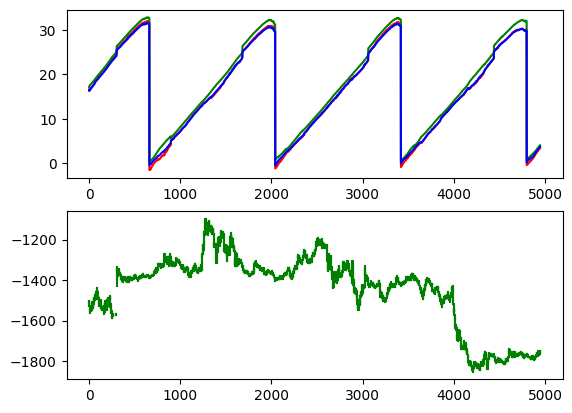

In [6]:
import matplotlib.pyplot as plt
short_predictions = [x[0][0] for x in outputs]
long_predictions = [x[0][1] for x in outputs]
neutral_predictions = [x[0][2] for x in outputs]


_, ax = plt.subplots(2,1)
ax[0].plot(short_predictions, c="r")
ax[0].plot(long_predictions, c="g")
ax[0].plot(neutral_predictions, c="b")


for index,i in enumerate(candle_position_history):
    o = i[0].o
    c = i[0].c
    if i[1] == -1:
        color = "r" 
    if i[1] == 1:
        color = "g" 
    if i[1] == 0:
        color = "b" 
    ax[1].plot([index,index],[o,c],c=color)

In [7]:
x.m1_candles[-1].t

[27, 5, 2022, 2, 27, 4]